**Auswertung:**

 - Negativ: Q-Funktion konvergiert weiterhin nicht
 - Negativ: Reward stagniert weriterhin
 - Positiv: Der Agent stabilisiert seinen Output, es wird der Setpoint nicht dauernd geändert

**Schlussfolgerung:**

 - Das quadratische / kubische Gewichtung der Anzahl der Septoint-Eingriffe / Abwichungen vom Target-Temp-Setpoint hat nicht das gewünschte Ergebnis gebracht.

In [1]:
import os
import sys
import ast
import pickle

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

In [3]:
import StateUtilities as SU

In [4]:
import visualization_helper_v2 as vh

In [5]:
fig_width = 16

In [6]:
dirnames = ["../checkpoints/s115/20210507-1443/",
            "../checkpoints/s116/20210507-1444/",
            "../checkpoints/s117/20210507-1445/",
            "../checkpoints/s118/20210507-1445/"]

In [7]:
alldfs = [ vh.convert_sqlite_to_df(dirname) for dirname in dirnames ]

Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.


In [8]:
vh.get_arguments_overview(dirnames)

,s115,s116,s117,s118
discount_factor,0.8,0.8,0.7,0.7
batch_size,512,512,256,256
reward_scale,0.5,0.05,0.125,0.125
reward_offset,0.1,0.25,0.2,0.2
stp_reward_function,cubic,quadratic,quadratic,quadratic
target_network_update_freq,7,7,6,6
epsilon_final_step,24000,24000,30000,30000
agent_network,"1HiddenBigLayer,SiLU","1HiddenBigLayer,SiLU","2HiddenLayer,Trapezium","2HiddenLayer,Trapezium,SiLU"
agent_w_l2,4e-06,1e-06,1.5e-06,1.5e-06
model,Building_5ZoneAirCooled_SingleSetpoint_SingleS...,Building_5ZoneAirCooled_SingleSetpoint_SingleS...,Building_5ZoneAirCooled_SingleSetpoint_SingleA...,Building_5ZoneAirCooled_SingleSetpoint_SingleA...


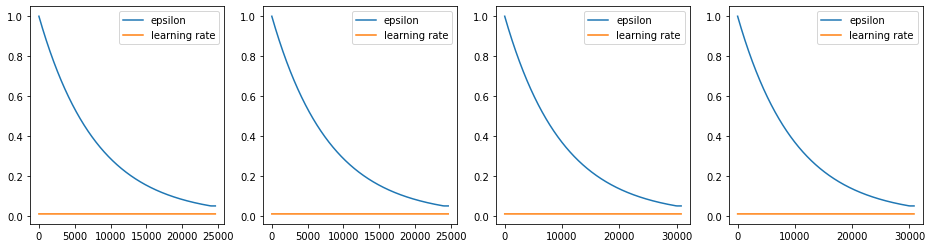

In [9]:
p, _ = vh.complete_plot_epsilon(alldfs, fig_width)
p.show()

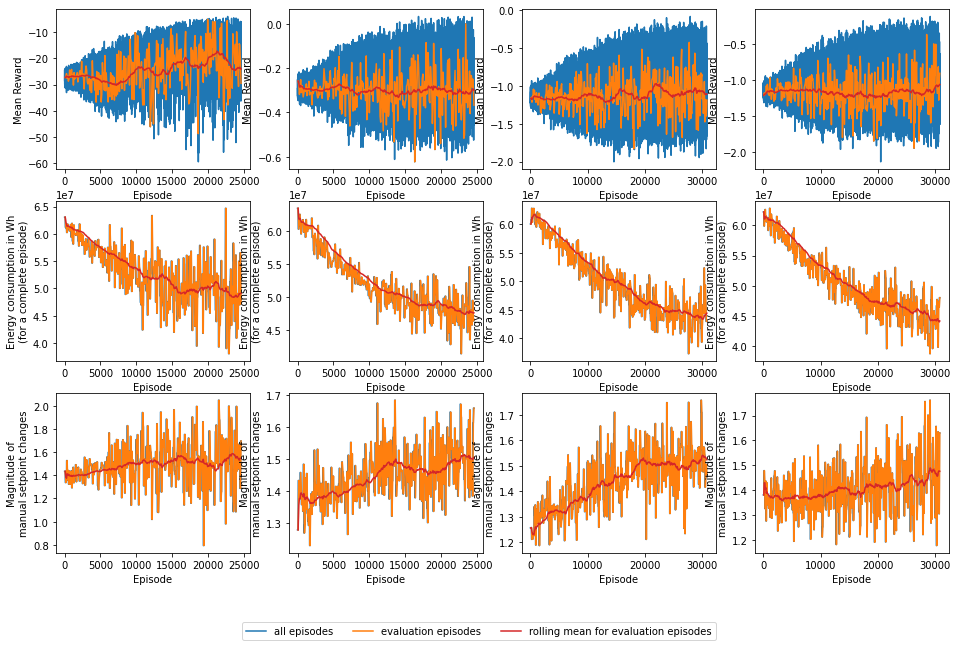

In [10]:
p, _ = vh.complete_plot_reward_stpc_econs(alldfs, fig_width)
p.show()

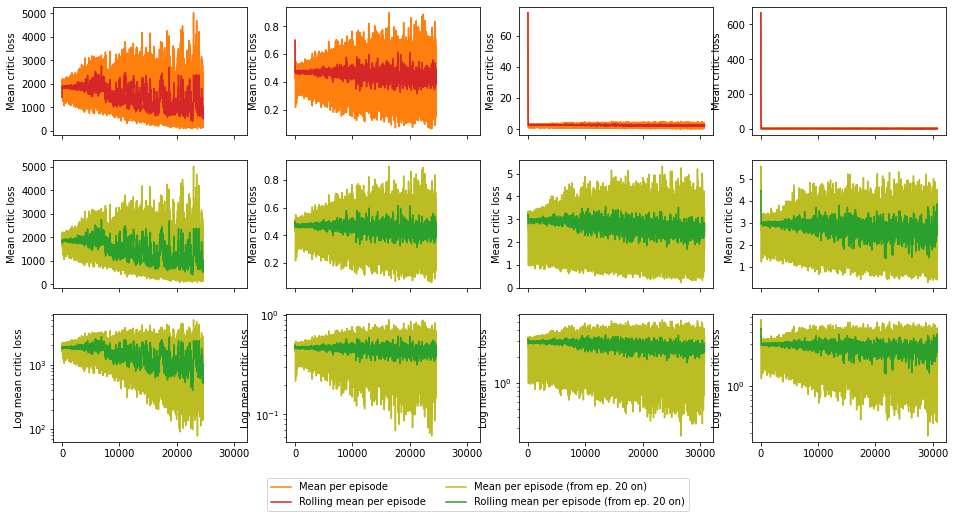

In [11]:
p, _ = vh.complete_plot_losses(alldfs, fig_width, with_agents=False)
p.show()

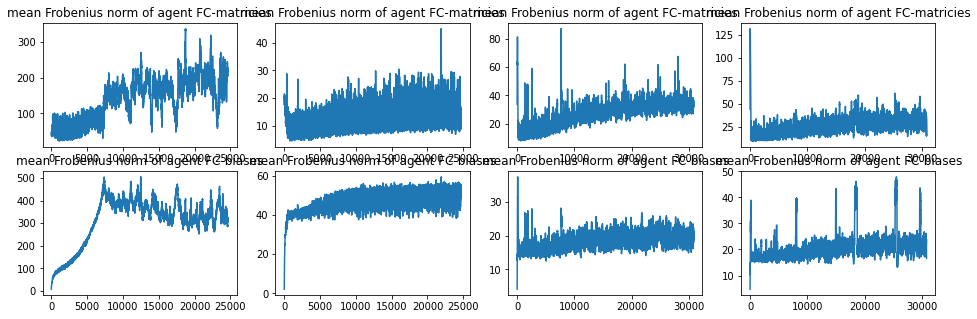

In [12]:
p, _ = vh.complete_plot_frobenius_norms(alldfs, fig_width, with_critics=False)
p.show()

In [13]:
last_available_eval_episodes = vh.compute_last_available_eval_episode(alldfs)

Last available evaluation episode for dfs0:  24639
Last available evaluation episode for dfs1:  24639
Last available evaluation episode for dfs2:  30799
Last available evaluation episode for dfs3:  30799


<h3>Details for one week</h3>

In [14]:
#selected_episodes = [13120 - 1, 14480 - 1, 14480 - 1]
#selected_weeks    = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1)]

In [15]:
if not "selected_episodes" in locals().keys():
    selected_episodes = last_available_eval_episodes.copy()
if not "selected_weeks" in locals().keys():
    # the start of the evaluation episode
    selected_weeks = [datetime.datetime.strptime(dfs['sees'].iloc[0]["datetime"], "%Y-%m-%d %H:%M:%S")
                      for dfs in alldfs]

subdfs = vh.select_week_and_episode_for_dfs_list(alldfs, selected_episodes, selected_weeks)

In [16]:
vh.print_reward_informations(subdfs, selected_episodes)

First complete week of evaluation episode
For episode 24639: Energy consumption:   47270.54 kWh; Numer of setpoint changes: 1220.0630491091115
For episode 24639: Energy consumption:   46591.90 kWh; Numer of setpoint changes: 1192.854768258986
For episode 30799: Energy consumption:   42968.39 kWh; Numer of setpoint changes: 1055.648536255021
For episode 30799: Energy consumption:   48008.07 kWh; Numer of setpoint changes: 1171.9037803087808

Mean values for episode ...
... 24639: Reward: -29.55647 kWh; Setpoint change magnit.:  1.69689; Energy cons.: 65744.84316
... 24639: Reward: -0.36690 kWh; Setpoint change magnit.:  1.65905; Energy cons.: 64800.97157
... 30799: Reward: -1.18839 kWh; Setpoint change magnit.:  1.46822; Energy cons.: 59761.31632
... 30799: Reward: -0.90327 kWh; Setpoint change magnit.:  1.62991; Energy cons.: 66770.61072


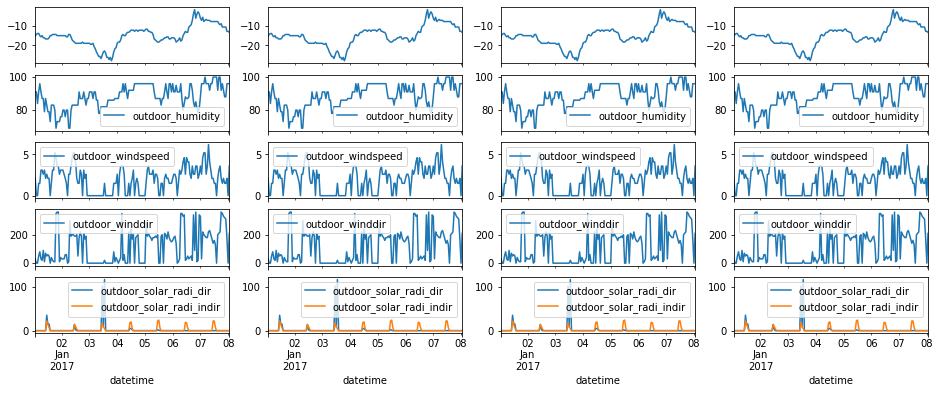

In [17]:
p, _ = vh.complete_plot_weather_information(subdfs, fig_width)
p.show()

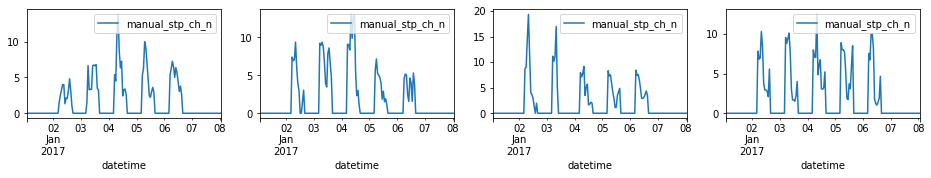

In [18]:
p, _ = vh.complete_plot_number_of_stp_ch(subdfs, fig_width)
p.show()

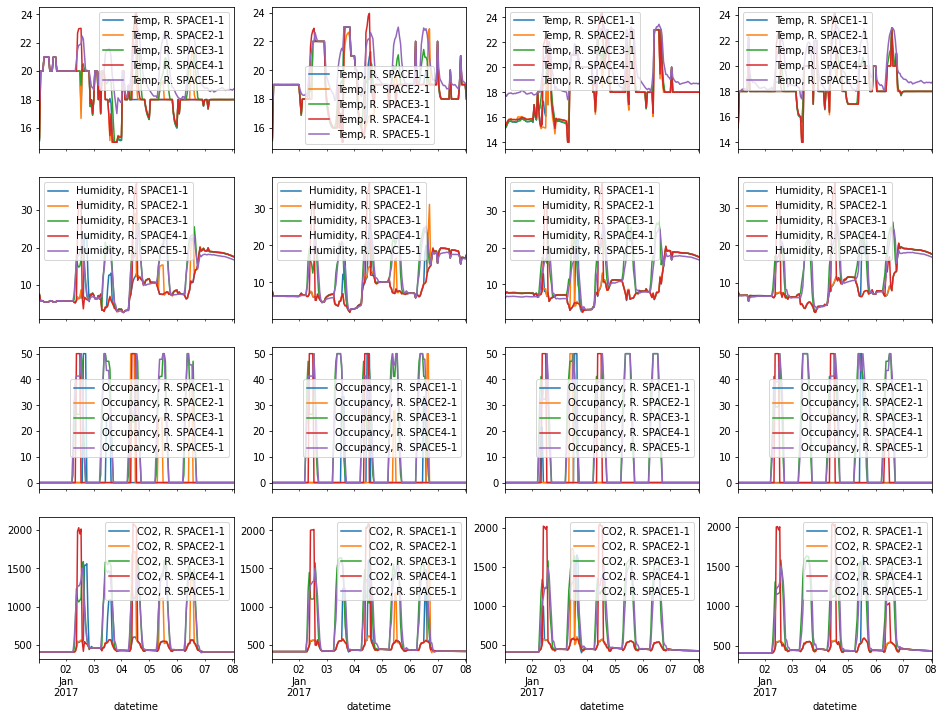

In [19]:
p, _ = vh.complete_plot_room_status(subdfs, fig_width)
p.show()

In [20]:
subdfs_rooms, subdfs_agents = vh.get_available_rooms_and_agents(subdfs)

Available Rooms     in (sub-)dfs0: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs0: [0] 

Available Rooms     in (sub-)dfs1: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs1: [0] 

Available Rooms     in (sub-)dfs2: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs2: [0] 

Available Rooms     in (sub-)dfs3: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs3: [0] 



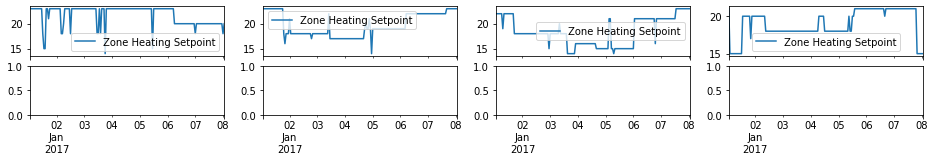

In [21]:
p, _ = vh.complete_plot_all_agent_outputs(subdfs, fig_width, subdfs_agents)
p.show()

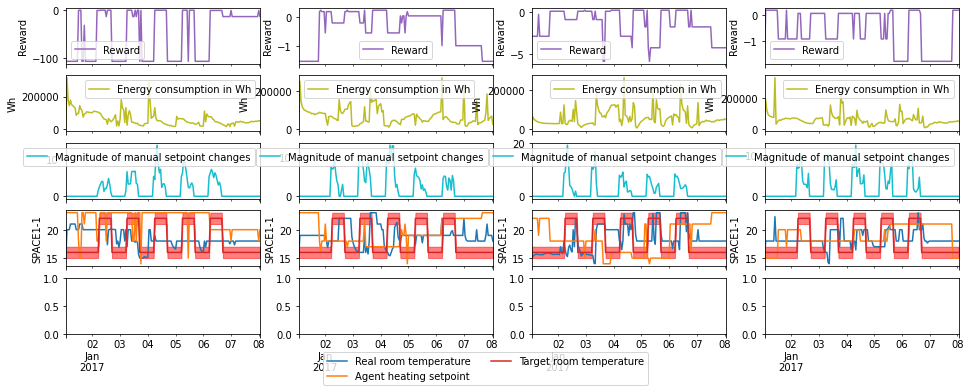

In [22]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a day</h3>

In [23]:
#selected_periods1    = [datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3)]
#selected_periods1_end= [datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4)]

In [24]:
if not "selected_periods1" in locals().keys():
    selected_periods1     = [datetime.datetime(2017, 1, 3) for _ in range(len(alldfs))]
if not "selected_periods1_end" in locals().keys():
    selected_periods1_end = [datetime.datetime(2017, 1, 4) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods1,
            selected_periods1_end)

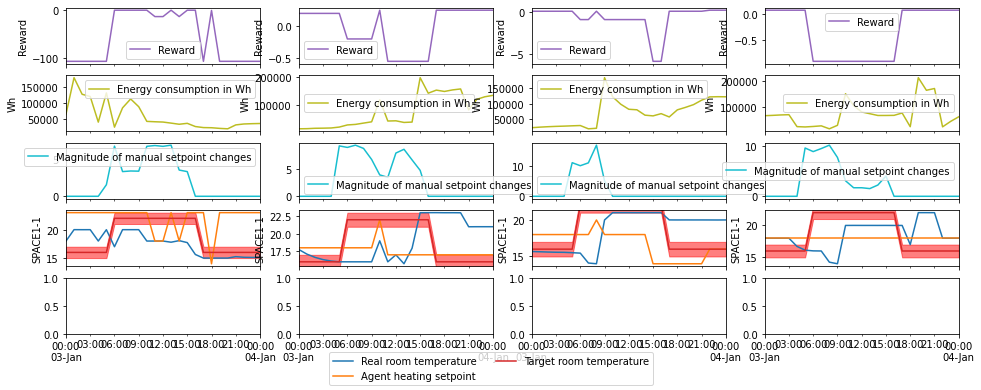

In [25]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a complete month</h3>

In [26]:
#selected_periods2    = [datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1)]

In [27]:
if not "selected_periods2" in locals().keys():
    selected_periods2     = [datetime.datetime(2017, 1, 1) for _ in range(len(alldfs))]
selected_periods2_end = [datetime.datetime(2017, 1, 30) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods2,
            selected_periods2_end)

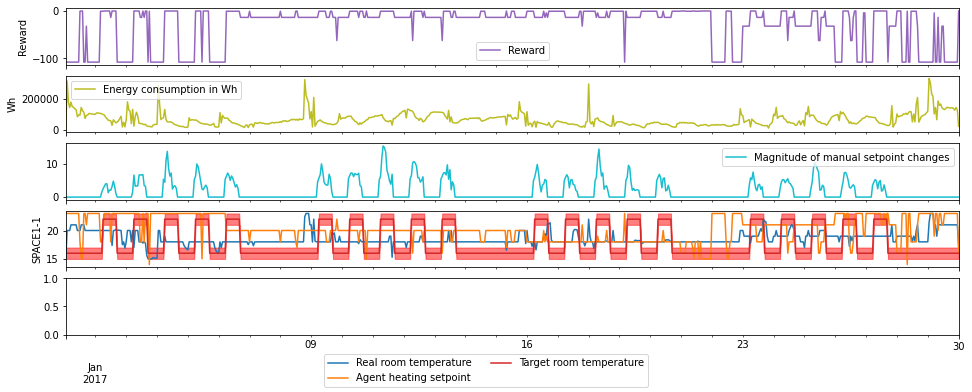

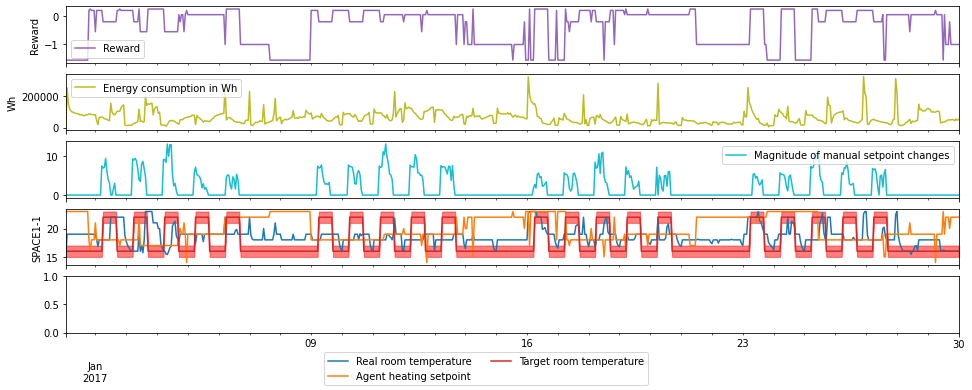

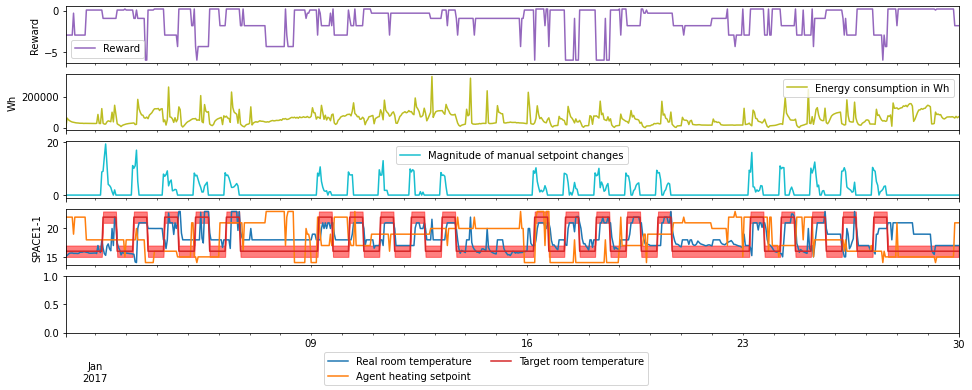

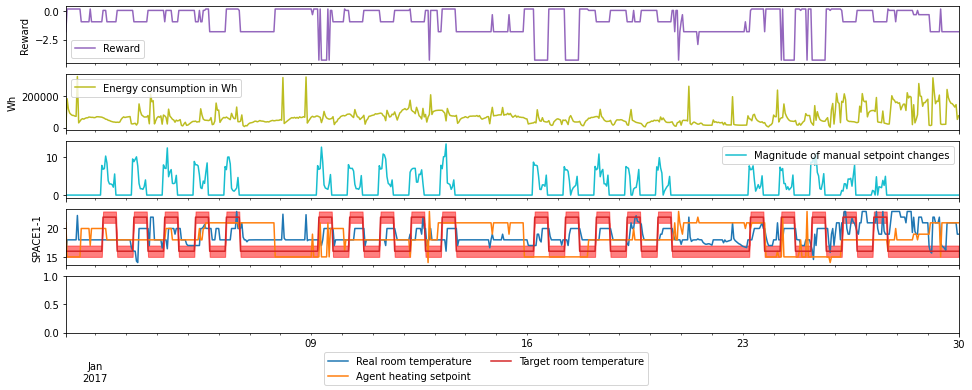

In [28]:
for idx, sdfs in enumerate(subdfs):
    p, _ = vh.complete_plot_total_overview(sdfs, fig_width,
                                           subdfs_rooms[idx],
                                           subdfs_agents[idx])
    p.show()